In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
%matplotlib inline

In [254]:
data = pd.read_csv('Auction_master_train.csv')

----
결측치 찾아서 대체하기

In [255]:
data.isnull().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_li                        1910
addr_san                          0
addr_bunji1                       4
addr_bunji2                    1044
addr_etc                          0
Apartment_usage             

In [256]:
# 결측치의 수가 적고, 주소 데이터가 틀리지 않았다면 결측치가 있을 수 없는 addr_bunji1 속성을 대체

In [257]:
data_isnull = data[data['addr_bunji1'].isnull()]

In [258]:
data_isnull['addr_etc']

1125               6구역13블럭15롯트 당고개센트럴 5층 503호
1312        내곡보금자리주택지구1블록 서초더샵포레 116동 6층 603호
1596    천왕도시개발사업지구4단지 천왕이펜하우스4단지 402동 6층 602호
1690        내곡보금자리주택지구1블록 서초더샵포레 111동 5층 501호
Name: addr_etc, dtype: object

In [259]:
# 결측치를 가진 데이터가 별다른 패턴을 가지지 않고, 단순히 누락된 것으로 보인다.
# 하지만 주소 데이터는 온전히 갖고 있다.
# 데이터의 수가 많지 않으므로 직접 번지수를 검색해서 수치를 넣었다.

In [260]:
data.loc[1125, 'addr_bunji1'] = 52.0
data.loc[1312, 'addr_bunji1'] = 77.0
data.loc[1596, 'addr_bunji1'] = 273.0
data.loc[1690, 'addr_bunji1'] = 77.0

----
범주형 변수 인코딩하기

In [261]:
print(data['Apartment_usage'].unique())
print(data['Bid_class'].unique())
print(data['addr_do'].unique())
print(data['addr_si'].unique())
print(data['Auction_class'].unique())
print(data['Share_auction_YorN'].unique())
print(data['Close_result'].unique())

#7가지 변수 모두 범주형 변수지만 명목형이다. 
#주소 관련 변수는 타겟변수인 hammer_price와 상관관계가 있을 것으로 보이는 두가지 변수를 선택했따.
#Apartment_usage, Bid_class, addr_do, addr_si 는 모두 one-hot encoding으로 처리하고, 
#Auction_class, Share_auction_YorN, Close_result 는 값이 2개만 존재하므로 1과 0으로 처리한다.
#
#이때 직관성을 높이기 위해 Auction_class는 forced_auction 으로, Close_result는 is_closed로, Share_auction_YorN은 share_auction으로 속성 이름을 변경한다.

['주상복합' '아파트']
['개별' '일반' '일괄']
['부산' '서울']
['해운대구' '사상구' '남구' '사하구' '영도구' '서구' '부산진구' '연제구' '수영구' '동래구' '동구' '중구'
 '강서구' '북구' '금정구' '기장군' '강남구' '은평구' '서초구' '영등포구' '양천구' '마포구' '금천구' '성동구'
 '노원구' '서대문구' '용산구' '구로구' '강북구' '관악구' '송파구' '도봉구' '광진구' '중랑구' '동대문구' '강동구'
 '성북구' '동작구' '종로구']
['임의' '강제']
['N' 'Y']
['배당' '    ']


In [262]:
dummy_var = pd.get_dummies(data.Apartment_usage)
data = pd.concat([data.drop(['Apartment_usage'], axis=1),dummy_var], axis=1)

dummy_var = pd.get_dummies(data.Bid_class)
data = pd.concat([data.drop(['Bid_class'], axis=1),dummy_var], axis=1)

dummy_var = pd.get_dummies(data.addr_do)
data = pd.concat([data.drop(['addr_do'], axis=1),dummy_var], axis=1)

dummy_var = pd.get_dummies(data.addr_si)
data = pd.concat([data.drop(['addr_si'], axis=1),dummy_var], axis=1)

In [263]:
data['Auction_class'] = data['Auction_class'].replace('임의', 0)
data['Auction_class'] = data['Auction_class'].replace('강제', 1)

data['Share_auction_YorN'] = data['Share_auction_YorN'].replace('N', 0)
data['Share_auction_YorN'] = data['Share_auction_YorN'].replace('Y', 1)

data['Close_result'] = data['Close_result'].replace('배당', 1)
data['Close_result'] = data['Close_result'].replace('    ', 0)

In [264]:
data.rename(columns={data.columns[1] : 'force_auction',
                    data.columns[28] : 'share_auction',
                    data.columns[33] : 'is_closed'}, inplace=True)

----
EDA

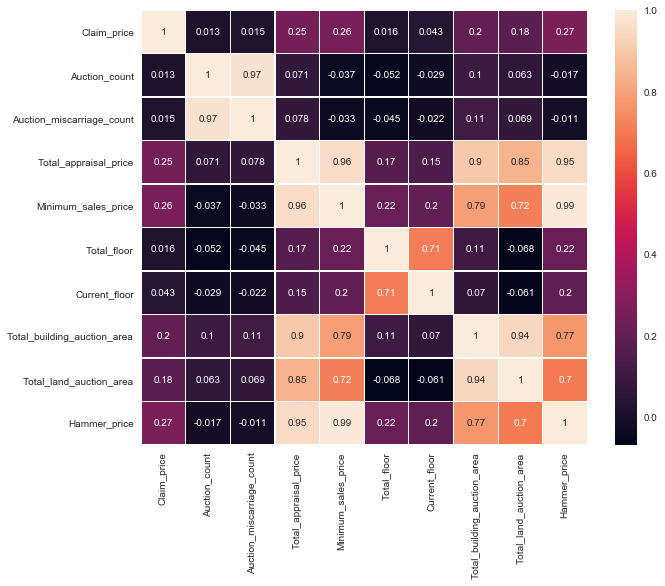

In [265]:
numerical_features = ['Claim_price', 'Auction_count', 'Auction_miscarriage_count', 'Total_appraisal_price', 'Minimum_sales_price', 'Total_floor', 'Current_floor', 'Total_building_auction_area', 'Total_land_auction_area', 'Hammer_price']
data[numerical_features].corr()

sns.heatmap(data[numerical_features].corr(),annot=True,linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [266]:
#대부분의 연속형 변수가 타겟 변수와 양의 상관관계를 보였다.
#경매 신청인의 청구 금액인 'Claim_price'는 생각보다 약한 상관관계를 보였다.
#또한 층수가 높은 건물이면 대체로 가격이 높지 않을까 생각했지만 유의미한 상관관계를 보이지는 않았다.

(0, 1000000000)

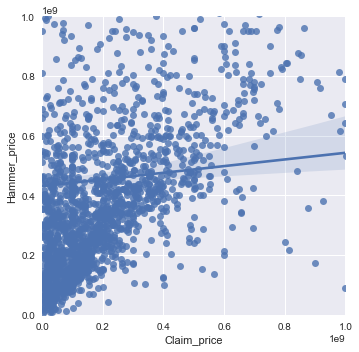

In [267]:
lm = sns.lmplot(x="Claim_price", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,1000000000)
axes[0,0].set_xlim(0,1000000000)

In [268]:
#Claim_price와 Hammer_price는 아주 약한 상관관계를 보이고 있다.
#대체로 경매 신청인의 청구금액보다 낙찰가가 더 높은 모습을 보인다. 

(0, 300)

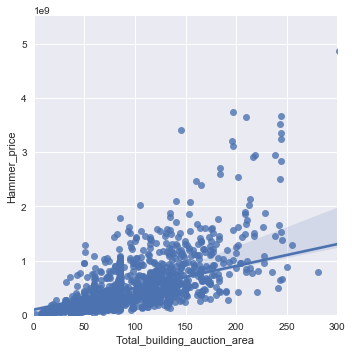

In [269]:
lm = sns.lmplot(x="Total_building_auction_area", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,5500000000)
axes[0,0].set_xlim(0,300)

In [270]:
#건물의 총 경매 면적인 Total_building_auction_area와는 비교적 높은 상관관계를 보이고 있다.
#면적이 넓을수록 매매가가 대체로 높다는 의미로 당연한 결과라고 볼 수 있다.

(0, 3500000000)

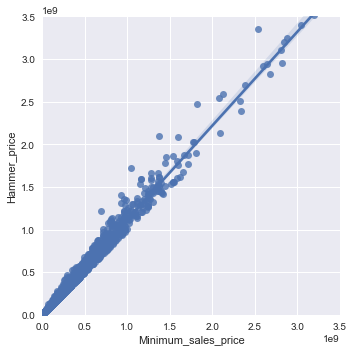

In [271]:
lm = sns.lmplot(x="Minimum_sales_price", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,3500000000)
axes[0,0].set_xlim(0,3500000000)

In [272]:
#Minumum sales price와 타겟변수는 서로 거의 일치하는 결과를 나타내고 있다.

(0, 80)

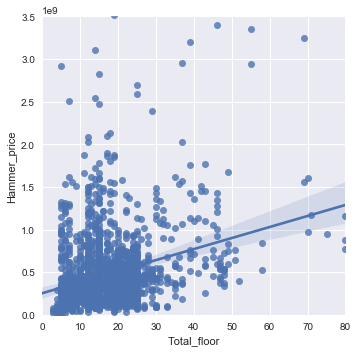

In [273]:
lm = sns.lmplot(x="Total_floor", y="Hammer_price", data=data)
axes = lm.axes
axes[0,0].set_ylim(0,3500000000)
axes[0,0].set_xlim(0,80)

In [274]:
#해당 건물의 층수를 의미하는 Total_floor와는 약한 상관관계를 보이고 있다. 
#즉 고층건물일수록 매매가가 비싼 경향은 있지만 상관관계는 0.2로 약하다.

(-1, 7)

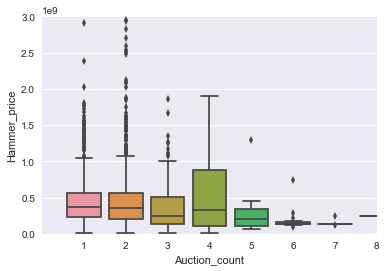

In [275]:
lm = sns.boxplot(x="Auction_count", y="Hammer_price", data=data)
lm.set_ylim(0,3000000000)
lm.set_xlim(-1,7)

In [276]:
#총경매횟수와는 아무런 관계가 없다고 보는 것이 타당해보인다.

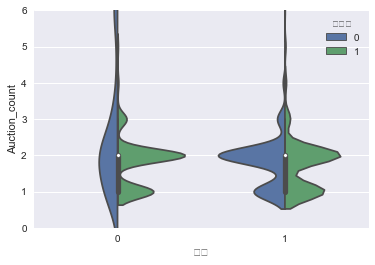

In [284]:
sns.violinplot("서울","Auction_count", hue="아파트", data=data,split=True).set_ylim(0, 6)
plt.show()

In [285]:
#부산과 서울의 총경매횟수를 아파트 / 주상복합으로 구분했다.
#파란색이 주상복합, 초록색이 아파트를 의미하고 왼쪽이 부산, 오른쪽이 서울이다.
#총경매횟수는 큰 의미가 없어보이며, 서울이 주상복합의 비중이 더 높다.

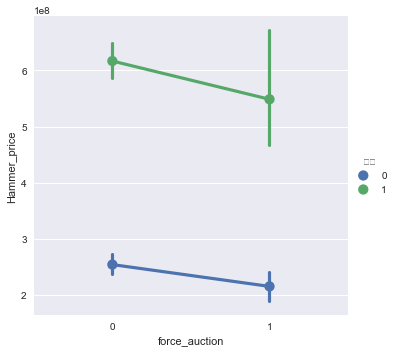

In [291]:
sns.factorplot('force_auction','Hammer_price',hue='서울',data=data)
plt.show()

In [292]:
#부산과 서울을 강제경매/임의경매로 구분해서 최종 경매가를 나타냈다.
#초록색 선이 서울, 파란색 선이 부산을 나타낸다. x값이 0인 경우 임의 경매를 의미하며 1인 경우 강제 경매를 의미한다.
#서울이 부산보다 최종 경매가가 높으며, 임의경매일 경우가 강제경매일 경우보다 매매가가 높다.

(0, 80)

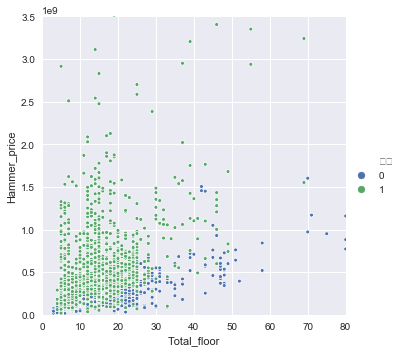

In [360]:
lm = sns.relplot(x="Total_floor", y="Hammer_price", hue="서울", data=data, s=15, x_jitter=100)
axes = lm.axes
axes[0,0].set_ylim(0,3500000000)
axes[0,0].set_xlim(0,80)

In [353]:
#초록색 점이 서울, 파란색 점이 부산을 의미하며, y축은 최종 경매가, x축은 건물의 층수를 의미한다.
#서울이 경매 건수가 훨씬 많으며 경매가가 높을수록 서울의 비중이 높다.
#단 고층 건물로 갈수록 부산의 비중이 더 높아지고 있다.